In [18]:
import ast
import time as time
import numpy as np
import pandas as pd
from area import area
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, recall_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap as shap

%matplotlib inline

In [19]:
SEED = 797
CV = 5

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [20]:
import mlflow

# S3 Object Storage of Yandex Cloud
%env AWS_REGION = ru-central1
%env AWS_ACCESS_KEY_ID = YCAJEpwWdAXRK3y0XVGo4WGCP
%env AWS_SECRET_ACCESS_KEY = YCNOlHXqnYoIEG7yzcqbXOsyLCJwbgNsv7Qil_hM

# MLflow
%env MLFLOW_SERVER_HOST = 51.250.20.38
%env MLFLOW_SERVER_PORT = 8000


mlflow.set_tracking_uri(
    f"http://{os.environ['MLFLOW_SERVER_HOST']}:{os.environ['MLFLOW_SERVER_PORT']}"
)
print(f"tracking MLflow URI: '{mlflow.get_tracking_uri()}'")
print(f"{mlflow.list_experiments()}")
mlflow.set_experiment("agroculture-classification-innopolis_cv")

env: AWS_REGION=ru-central1
env: AWS_ACCESS_KEY_ID=YCAJEpwWdAXRK3y0XVGo4WGCP
env: AWS_SECRET_ACCESS_KEY=YCNOlHXqnYoIEG7yzcqbXOsyLCJwbgNsv7Qil_hM
env: MLFLOW_SERVER_HOST=51.250.20.38
env: MLFLOW_SERVER_PORT=8000
tracking MLflow URI: 'http://51.250.20.38:8000'
[<Experiment: artifact_location='/home/brut0/mlflow/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>, <Experiment: artifact_location='/home/brut0/mlflow/mlruns/1', experiment_id='1', lifecycle_stage='active', name='my-experiment-1', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/2', experiment_id='2', lifecycle_stage='active', name='my-experiment-2', tags={}>, <Experiment: artifact_location='s3://kaggle-mining-process/3', experiment_id='3', lifecycle_stage='active', name='my-experiment-3', tags={}>, <Experiment: artifact_location='s3://kaggle-mining-process/4', experiment_id='4', lifecycle_stage='active', name='my-experiment-4', tags={}>, <Experiment: artifact_location='mlflow-artifacts:

<Experiment: artifact_location='mlflow-artifacts:/8', experiment_id='8', lifecycle_stage='active', name='agroculture-classification-innopolis_cv', tags={}>

In [21]:
df_train = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv('test_dataset_test.csv')
solution = pd.read_csv('sample_solution.csv')

In [22]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df['.geo_lat'] = df['.geo'].apply(lambda x: 
                                        ( 
                                            ast.literal_eval(x)['coordinates'][0][0][0][0] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][0], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][0]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][0]
                                    )
    df['.geo_lon'] = df['.geo'].apply(lambda x: 
                                        (
                                            ast.literal_eval(x)['coordinates'][0][0][0][1] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][1], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][1]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][1]
                                    )
    df['.geo_area'] = df['.geo'].apply(lambda x: area(ast.literal_eval(x))) / 10000
    ndvi_columns = [nd for nd in df.columns if 'nd_mean' in nd]
    df['ndvi_miss_count'] = df[ndvi_columns].eq(0).sum(axis=1)
    df['ndvi_max'] = df[ndvi_columns].max(axis=1)
    df['.geo_zone'] = 0
    df.loc[(df['.geo_lat'] < 35.5) & (df['.geo_lon'] < 54), '.geo_zone'] = 1
    df.loc[(df['.geo_lat'] > 35.5) & (df['.geo_lat'] < 38) & (df['.geo_lon'] < 54), '.geo_zone'] = 2
    df.loc[(df['.geo_lat'] > 38) & (df['.geo_lat'] < 44) & (df['.geo_lon'] < 52.5), '.geo_zone'] = 3
    df.loc[(df['.geo_lat'] > 43) & (df['.geo_lat'] < 47) & (df['.geo_lon'] > 54), '.geo_zone'] = 4
    df.loc[(df['.geo_lat'] > 47), '.geo_zone'] = 5
    return df

In [23]:
NUM_FEATURES = [
       '.geo_area', 'area',
       'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
       'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04',
       'nd_mean_2021-08-10', 'nd_mean_2021-08-23', 'nd_mean_2021-04-20',
       'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05',
       'nd_mean_2021-06-10', 'nd_mean_2021-07-05', 'nd_mean_2021-08-13',
       'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24',
       '.geo_lat', '.geo_lon', 'ndvi_miss_count', 'ndvi_max', '.geo_zone',
]
ALL_FEATURES = NUM_FEATURES
TARGET = 'crop'

In [24]:
X = add_features(data=df_train)[ALL_FEATURES]
y = df_train[TARGET]

X_test = add_features(data=df_test)[ALL_FEATURES]

## Train model

In [25]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=SEED)

In [26]:
models = {
    'XGBoost': {
        'model': XGBClassifier(),
        'features': list(set(ALL_FEATURES) - set(['.geo_area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone'])),
        'feature_importance': 0
    },

    'LightGBM 1': {
        'model': LGBMClassifier(),
        'features': list(set(ALL_FEATURES) - set(['area', 'ndvi_miss_count', 'ndvi_max'])),
        'feature_importance': 0
    },

    'LightGBM 2': {
        'model': LGBMClassifier(),
        'features': list(set(ALL_FEATURES) - set(['area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone'])),
        'feature_importance': 0
    },

    # 'CatBoost': {
    #     'model': CatBoostClassifier(
    #         objective = 'MultiClass',
    #         eval_metric = 'TotalF1',
    #         depth = 9,
    #         iterations = 8000,
    #         bootstrap_type = 'Bernoulli',
    #         l2_leaf_reg = 8,
    #         min_data_in_leaf = 8,
    #         class_weights = [1.2, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0],
    #         colsample_bylevel = 0.8165067314653208,
    #         verbose = False,
    #         random_seed = SEED
    #     ),
    #     'features': list(set(ALL_FEATURES) - set(['.geo_area', '.geo_zone'])),
    #     'feature_importance': 0
    # },
}

In [27]:
for m in models:
    print(f"{m}:")
    X[m] = np.zeros((X.shape[0],))
    predictions_valid = np.zeros((X.shape[0],))
    mean_score = 0
    
    start_time = time.time()
    for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        # split the train data into train and validation
        X_train = X.iloc[train_idx][models[m]['features']]
        X_valid = X.iloc[valid_idx][models[m]['features']]
        y_train = y.iloc[train_idx]
        y_valid = y.iloc[valid_idx]
        
        model = models[m]['model']
        model.fit(X_train, y_train,
                  eval_set = [(X_valid, y_valid)],
                  verbose = False
                 )
        
        # Mean of feature importance
        models[m]['feature_importance'] += model.feature_importances_ / CV 
        
        # Out of Fold predictions
        predictions_valid[valid_idx] = model.predict(X_valid)
        fold_score = recall_score(y_valid, predictions_valid[valid_idx], average='macro')
        print(f"Fold {num} | Recall: {fold_score:.4f}")
        
        mean_score += fold_score / CV
        
    X[m] = predictions_valid
    print(f"Overall Recall: {mean_score:.6f}")
    print(f"Trainig time: {time.time()-start_time:.1f}\n")

XGBoost:
Fold 0 | Recall: 0.9698
Fold 1 | Recall: 0.9774
Fold 2 | Recall: 0.9707
Fold 3 | Recall: 0.9664
Fold 4 | Recall: 0.9655
Overall Recall: 0.969956
Trainig time: 19.1

LightGBM 1:
Fold 0 | Recall: 0.9678
Fold 1 | Recall: 0.9796
Fold 2 | Recall: 0.9738
Fold 3 | Recall: 0.9725
Fold 4 | Recall: 0.9666
Overall Recall: 0.972033
Trainig time: 8.4

LightGBM 2:
Fold 0 | Recall: 0.9678
Fold 1 | Recall: 0.9754
Fold 2 | Recall: 0.9758
Fold 3 | Recall: 0.9725
Fold 4 | Recall: 0.9666
Overall Recall: 0.971604
Trainig time: 8.0



In [32]:
predictions = pd.DataFrame()
for m in models:
    print(f"{m}")
    start_time = time.time()
    model = models[m]['model']
    model.fit(X[models[m]['features']], y, verbose = False)
    predictions[m] = model.predict(X_test[models[m]['features']])
        
X_test = pd.concat([X_test, predictions], axis=1)
print(f"Trainig time: {time.time()-start_time:.1f}\n")

XGBoost:
LightGBM 1:
LightGBM 2:
Trainig time: 1.4



In [43]:
submit = 'submit_44_blend'

FINAL_FEATURES = list(set(X.columns) - set(['area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone']))

clf = LGBMClassifier()
clf.fit(X[FINAL_FEATURES], y)

predictions = clf.predict(X_test[FINAL_FEATURES])
solution.crop = predictions
solution.to_csv(f"{submit}.csv", index=False)

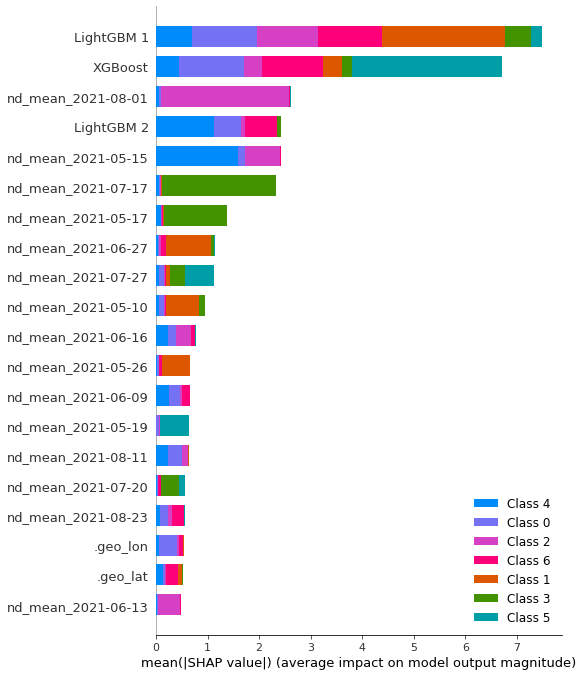

In [45]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X[FINAL_FEATURES])
shap.summary_plot(shap_values, X[FINAL_FEATURES], feature_names=FINAL_FEATURES)

In [46]:
feature_importance_df = pd.DataFrame(clf.feature_importances_, index=FINAL_FEATURES)
feature_importance_df.sort_values(by=0, ascending=False)

,0
LightGBM 1,961
nd_mean_2021-05-15,732
.geo_lat,696
XGBoost,668
.geo_lon,503
nd_mean_2021-07-27,455
LightGBM 2,427
nd_mean_2021-06-16,407
nd_mean_2021-05-10,368
nd_mean_2021-06-09,365
